# Bandit Experiments

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector
from qiskit.circuit.classical import expr
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakePerth
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_error_map, plot_distribution
from qiskit.result.mitigation import base_readout_mitigator

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set_style('dark')

In [8]:
# HELPER FUNCTIONS

def generate_random_states(n=1000):
    random_list = [np.random.uniform(size=n)*pow(1j, (i%2)) for i in range(8)]
    random_state = []
    for i in range(0, 8, 2):
        random_state.append(random_list[i] + random_list[i+1])
    random_state = np.array(random_state).T
    for idx, row in enumerate(random_state):
        # row /= np.sum(np.abs(row))
        row /= np.sqrt(pow(np.abs(row), 2).sum())

    return random_state

In [9]:
def generate_product_states(n=1000):
    theta1 = np.random.uniform(0, 2*np.pi, size=n)
    theta2 = np.random.uniform(0, 2*np.pi, size=n)
    phi1 = np.random.uniform(0, np.pi, size=n)
    phi2 = np.random.uniform(0, np.pi, size=n)
    random_state = [np.cos(theta1)*np.cos(theta2), np.cos(theta1)*np.exp(1j*phi2)*np.sin(theta2), np.exp(1j*phi1)*np.sin(theta1)*np.cos(theta2), np.exp(1j*(phi1+phi2))*np.sin(theta1)*np.sin(theta2)]
    return np.array(random_state).T

In [10]:
def get_k(state):
    a, b, c, d = state
    r = np.abs(a*d-b*c).item()**2
    if r < 1e-30:
        return 0
    return r

def post_process_bitstrings(bitstrings):
    res = np.zeros(len(bitstrings))
    for idx, bitstr in enumerate(bitstrings):
        if bitstr in ['1 0 0 1', '1001', '0 0 1 1', '0011']:
            res[idx] = 1
    return res

In [11]:
np.random.seed(20)

k = generate_random_states(1000)
w = generate_product_states(1000)

### LOCC Circuit Builder

In [12]:
def build_locc_circuit(initial_state):
    c1 = ClassicalRegister(1)
    c2 = ClassicalRegister(1)
    c3 = ClassicalRegister(1)
    c4 = ClassicalRegister(1)
    # cbits = ClassicalRegister(4, 'meas')
    qbits = QuantumRegister(4)
    
    qc = QuantumCircuit(qbits, c1, c2, c3, c4)
    
    initial_state = Statevector(initial_state)
    tensor_state = initial_state^initial_state
    qc.initialize(tensor_state) # to initialize with any state
    
    # qc.x(0)
    # # qc.x(1)
    # qc.x(2)
    # # qc.x(3)
    
    qc.barrier()
    qc.measure(1, 1)
    qc.measure(3, 3)
    qc.barrier()
    # qc.cx(0, 2)
    # qc.cx(0, 2)
    
    with qc.if_test(expr.equal(expr.bit_xor(c2, c4), 1)):
        # qc.x(0)
        qc.cx(0, 2)
        qc.cx(2, 0)
        # qc.ry(np.pi/4, 1)   #
        # qc.ccx(3, 2, 1)     # (For cch gate)   
        # qc.ry(-np.pi/4, 1)  #
        qc.cz(2, 0)
        qc.ch(2, 0)
        qc.cx(2, 0)
        qc.cx(0, 2)
        
    # qc.cx(0, 2)
    qc.barrier()
    # qc.measure(0, 0)
    qc.measure(0, 0)
    # qc.measure(2, 2)
    qc.measure(2, 2)

    return qc

## (m,n) Multi-armed bandits problem

We have *n* arms out of which *m* have distillable entanglement greater than some threshold $\beta$.

In [13]:
np.random.seed(20)

n_arms = 7
random_ids = np.random.choice(range(len(k)), size=n_arms)

In [14]:
arms = k[random_ids]

In [15]:
val = np.array([get_k(arm) for arm in arms])
print("The Values of K are : ", val)
print("Average Value of K : ", np.mean(val))

The Values of K are :  [0.11030283 0.09109354 0.00148992 0.1337458  0.00015782 0.03220025
 0.06711584]
Average Value of K :  0.062300856097519945


Algorithm:

We sample each round and build confidence bounds. We remove arms whose $UCB_t < \beta$ and declare them as weakly entangled and for arms whose $LCB_t > \beta$, we can declare them as having distillable entanglement more than $\beta$. We continue this untill the set is completely empty. 

In [16]:
arms_idx = set(list(range(len(arms))))

In [17]:
n = 1000000
bitstrings = []
aer_sim = AerSimulator()

for idx, arm in enumerate(arms):
    circuit = build_locc_circuit(arm)
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, seed_transpiler=20)
    isa_qc = pm.run(circuit)
    job = aer_sim.run([isa_qc], shots=n, seed_simulator=20, memory=True)
    result = job.result()
    bitstrs = result.get_memory()
    bitstrings.append(post_process_bitstrings(bitstrs))

bitstrings = np.array(bitstrings).T

In [18]:
# # Algorithm

# def m_n_problem(bitstrings, n_arms, arms_idx, beta, error_prob=0.01, history=False):
#     estimated_mean = np.zeros(n_arms)
#     stopping_times = np.zeros(n_arms).astype(np.uint32)
#     ucb_track = []
#     lcb_track = []
#     mean_track = []
    
#     weak = list()
#     strong = list()
    
#     max_iter = 1000000

#     iteration = 0
#     while len(arms_idx)>0 and iteration < max_iter:

#         samples = bitstrings[iteration]
#         estimated_mean = (estimated_mean*(iteration) + samples)/(iteration + 1)
#         mean_track.append(estimated_mean)
        
#         bound = np.sqrt(np.log(1/error_prob)/(2*(iteration+1)))
#         ucb = estimated_mean + bound
#         ucb_track.append(ucb)
#         lcb = estimated_mean - bound
#         lcb_track.append(lcb)

#         marked = []
#         for arm in arms_idx:
#             if ucb[arm] < beta:
#                 weak.append(arm)
#                 marked.append(arm)

#             elif lcb[arm] >= beta:
#                 strong.append(arm)
#                 marked.append(arm)

#         for arm in marked:
#             stopping_times[arm] = iteration + 1
#             arms_idx.remove(arm)
        
#         iteration += 1

#     if iteration == max_iter:
#         print("MAX ITERATION REACHED !!")

#     if not history:
#         return sorted(weak.copy()), sorted(strong.copy()), iteration

#     return sorted(weak.copy()), sorted(strong.copy()), iteration, [np.array(mean_track), np.array(ucb_track), np.array(lcb_track), stopping_times]

In [13]:
# weak_arms, strong_arms, n_iters, history = m_n_problem(bitstrings, len(arms), arms_idx.copy(), 0.05, history=True)

In [14]:
# mean_t, ucb_t, lcb_t, stop_t = history 

In [15]:
# for i in arms_idx:
#     plt.fill_between(range(1, n_iters+1), y1=lcb_t[:, i], y2=ucb_t[:, i], alpha=0.2)
#     plt.plot(range(1, n_iters+1), mean_t[:, i])
# plt.axhline(0.05, ls='dashed', color='black')
# # plt.ylim(0, 0.126)
# plt.ylabel("$|\hat{K}|^2$")
# plt.xlabel("No. of Rounds (n)")
# plt.title("Successive Elimination of Arms")
# plt.savefig('confidence_bounds.jpg', dpi=500)
# plt.show()

### Good-Arm Identification

We will use **lil'HDoc** algorithm to find the good arms

In [19]:
# def successive_elimination(bitstrings, n_arms, arms_idx, error_prob=0.2, epsilon=0.01, history=False):
#     estimated_mean = np.zeros(n_arms)
#     max_iters = 10000000
#     iter_idx = np.zeros(n_arms).astype(int)
#     prev_arm = None
    
#     iteration = 0
#     k = 1 # Multiplier

#     def cfunc(n, delta, n_arms):
#         x = np.log((n_arms-1)/(2*delta)) + 4*np.log(4 + np.log(n/2))
#         return 2*(x+np.log(x))
    
#     while iteration < k*n_arms:
#         prev_arm = iteration%n_arms
#         sample = bitstrings[iter_idx[prev_arm], prev_arm]
#         estimated_mean[prev_arm] = (estimated_mean[prev_arm]*iter_idx[prev_arm] + sample)/(iter_idx[prev_arm]+1)
#         iter_idx[prev_arm] += 1
#         iteration += 1

#     while len(arms_idx) > 1 and iteration < max_iters:
#         # sample = bitstrings[iter_idx[prev_arm]]
#         # estimated_mean = (estimated_mean*(iteration) + samples)/(iteration + 1)
#         bound = np.sqrt(3*np.log(1/error_prob)/(8*(iter_idx)))
#         ucb = estimated_mean + bound
#         # ucb[ucb>0.25] = 0.25
#         lcb = estimated_mean - bound
#         # lcb[lcb<0] = 0
#         # print(f"Round : {iteration} - UCB : {ucb}, LCB : {lcb}")

#         # marked = []
#         # for arm in arms_idx:
#         #     if len(lcb[ucb[arm] < lcb]) > 0:
#         #         marked.append(arm)
#         # for arm in marked:
#         #     arms_idx.remove(arm)

#         ################################
#         # STOPPING RULE 
#         ################################
#         prev_arm = list(arms_idx)[np.argmax(ucb[list(arms_idx)])]
#         ex_idx = np.ones(n_arms, dtype=bool)
#         ex_idx[prev_arm] = False

#         mean_dif = estimated_mean[prev_arm] - estimated_mean
#         mean_dif = mean_dif[ex_idx]
#         valid_dif = mean_dif
#         sub_pulls = np.sqrt(1/iter_idx[prev_arm] + 1/iter_idx[ex_idx])
#         criterion = min((valid_dif + epsilon)/sub_pulls)
#         threshold = np.sqrt(2*cfunc(iteration-1, error_prob, n_arms))
#         if iteration % 100 == 0:
#             print(f'Threshold : {threshold}, Criterion : {criterion}', end='\r')
#         if criterion >= threshold:
#             return np.argmax(ucb), iteration
        
        
        
#         prev_arm = list(arms_idx)[np.argmax(ucb[list(arms_idx)])]
#         sample = bitstrings[iter_idx[prev_arm], prev_arm]
#         estimated_mean[prev_arm] = (estimated_mean[prev_arm]*iter_idx[prev_arm] + sample)/(iter_idx[prev_arm] + 1)
#         iter_idx[prev_arm] += 1
                
#         iteration += 1

#     return np.argmax(ucb), iteration

In [37]:
def U_bound(eps, t, w):
    return (1+np.sqrt(eps))*np.sqrt(2*(1/4)*(1+eps)*np.log(np.log((1+eps)*t)/w)/t)

def lilHDoC(bitstrings, n_arms,  arms_idx, error_prob=0.01, threshold=0.02, bound_method='lil'):
    np.random.seed(20)
    estimated_mean = np.zeros(n_arms)
    iter_idx = np.zeros(n_arms).astype(int)
    max_iters = 10000000
    prev_arm = None
    good_arms = []
    bad_arms = []

    # Params
    b = n_arms + 1
    c = max(1/error_prob, np.e)
    eps = np.linspace(0, 1, endpoint=True, num=1000000)
    r = (1+np.sqrt(eps))**2*(1+eps)
    eps_prime = eps[np.argmax(r[r<=1+min(np.log(np.log(b))/np.log(b), np.log(np.log(c))/np.log(c))])]
    # print(f"Eps Prime : {eps_prime}")
    r = (1+np.sqrt(eps_prime))**2*(1+eps_prime)
    # print(f"R : {r}")

    c_eps = (2 + eps_prime)/eps_prime * pow(1/np.log(1 + eps_prime), 1 + eps_prime)
    # print(f"C_Eps : {c_eps}")
    thres = 0.25*(pow(n_arms/error_prob, r-1)*pow(c_eps, r))
    # print(f'Thres : {thres}')
    
    # Binary Search for T
    for t in range(1, 100000):
        if t*t/pow(np.log((1+eps_prime)*t), r) >= thres:
            T = t
            # print(f"T : {T}")
            break

    for idx in arms_idx:
        estimated_mean = np.mean(bitstrings[:T, :], axis=0)
        iter_idx = np.ones(n_arms, dtype=int)*(T)

    iteration = n_arms*T + 1
    while len(arms_idx) > 0 and iteration < max_iters:
        # if iteration % 100000 == 0:
            # print(f'Iteration : {iteration}, Good Arms : {good_arms}, Bad Arms : {bad_arms}, Iters : {iter_idx}', end='\r')
        
        ids = list(arms_idx)
        u_t = np.sqrt(np.log(iteration)/(2*iter_idx[ids]))
        # arm = ids[np.argmax(estimated_mean[ids] + u_t)]
        b = estimated_mean[ids] + u_t
        arm = ids[np.random.choice(np.where(b == b.max())[0])]

        # Pulling arm
        # print(iter_idx[arm], arm)
        sample = bitstrings[iter_idx[arm], arm]
        estimated_mean[arm] = (estimated_mean[arm]*iter_idx[arm] + sample)/(iter_idx[arm] + 1)
        iter_idx[arm] += 1

        # Elimination
        if bound_method =='lil':
            bound = U_bound(eps_prime, iter_idx[arm], error_prob/(c_eps*n_arms))
        else:
            bound = np.sqrt(np.log(1/error_prob)/(2*(iter_idx[arm]+1)))

        if estimated_mean[arm] - bound >= threshold:
            good_arms.append(arm)
            arms_idx.remove(arm)
        elif estimated_mean[arm] + bound < threshold:
            bad_arms.append(arm)
            arms_idx.remove(arm)

        iteration += 1

    return good_arms, bad_arms, iteration, T

In [38]:
good, bad, stop, T = lilHDoC(bitstrings, len(arms_idx), arms_idx.copy(), error_prob=0.1, threshold=0.04)

In [39]:
val[good]

array([0.1337458 , 0.11030283, 0.09109354, 0.06711584])

In [40]:
val[bad]

array([0.03220025, 0.00148992, 0.00015782])

In [41]:
T*len(arms_idx)

8071

In [42]:
stop

198739

In [50]:
conf = np.logspace(-3, -1, endpoint=True, num=40)
stopping_time_1 = []
# stopping_time_2 = []

for c in conf:
    good, bad, stop_1, T = lilHDoC(bitstrings, len(arms_idx), arms_idx.copy(), error_prob=c, threshold=0.05, bound_method='lil')
    # good, bad, stop_2 = lilHDoC(bitstrings, len(arms_idx), arms_idx.copy(), error_prob=c, threshold=0.03, bound_method='ucb')
    stopping_time_1 += [stop_1]
    # stopping_time_2 += [stop_2]

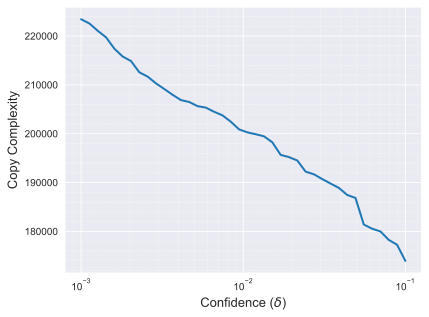

In [51]:
plt.semilogx(conf, 2*np.array(stopping_time_1), lw=2)
# plt.semilogx(conf, stopping_time_2, label='Specific Confidence Bound')
plt.grid()
plt.grid(which='minor', ls=':', lw=0.5)
plt.minorticks_on()
plt.xlabel("Confidence ($\delta$)", labelpad=5, fontsize=13)
plt.ylabel("Copy Complexity", labelpad=5, fontsize=13)
# plt.legend()
plt.savefig('copy_complexity_vs_confidence_lilhdoc.jpg', dpi=600, bbox_inches='tight')

In [52]:
df = pd.DataFrame(np.array([conf, stopping_time_1]).T, columns=["Confidence", "Stopping Time"])

In [53]:
df.to_csv("Stopping_time_vs_Confidence.csv", index=None)